In [1]:
# Fail
import matplotlib.pyplot as plt
import numpy as np

from pydrake.all import *

# Start the visualizer.
import warnings
warnings.filterwarnings("ignore")

meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [2]:
class PointFingerForceControl(LeafSystem):
    

    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant

        self.sensed_wrench=np.array([0,0,0,0,0,0])
        
        self.DeclareAbstractInputPort("ATIs", Value[List[SpatialForce]]())    
        
        self.DeclareAbstractOutputPort("spatial_forces", 
            lambda: AbstractValue.Make([ExternallyAppliedSpatialForce() for i in range(1)]),
            self.execute_realtime)  
         
            
    def execute_realtime(self, context, output):


 # add force
        body_peg=self._plant.GetBodyByName("cake")
        force_object = ExternallyAppliedSpatialForce()
        force_object.p_BoBq_B = np.array([0,  0, 0]) # world 0, 0, 0
        force_object.body_index = body_peg.index()
        force_object.F_Bq_W = SpatialForce(tau=np.array([0, 0, 0]), f=np.array([1, 0, 0]))  
        forces=[]
 
        forces.append(force_object)
        output.set_value(forces)
        

#### find sensed force
        spatial_vec = self.get_input_port(0).Eval(context)
        sensor_joint_index_z = self._plant.GetJointByName("weld_joint").index()

        if len(spatial_vec)>0:

            wrench_z=spatial_vec[sensor_joint_index_z].get_coeffs()

            self.sensed_wrench = np.vstack((self.sensed_wrench, wrench_z))                   
        else:
            self.sensed_wrench = np.vstack((self.sensed_wrench, [0,0,0,0,0,0]))       

        

In [3]:
# build the scene
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)

parser = Parser(plant)
box=parser.AddModelFromFile("cake.sdf")
frame = plant.AddFrame(FixedOffsetFrame("frame",plant.world_frame(), 
                                                        RigidTransform(RotationMatrix.MakeYRotation(0/180*np.pi),
                                                                    [-1,0,0.05])))   
joint_sensor = plant.AddJoint(
    PrismaticJoint("joint_sensor", plant.GetFrameByName("frame"),
                    plant.GetFrameByName("cake"), [1, 0, 0], -5, 5))  

right_finger = parser.AddModelFromFile("valve_v1.sdf")
weld = plant.AddJoint(WeldJoint("weld_joint", plant.world_frame(), plant.GetFrameByName("valve"), RigidTransform()))


plant.Finalize()



MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
ContactVisualizer.AddToBuilder(
    builder, plant, meshcat,
    ContactVisualizerParams(radius=0.005))

# add system

controller = builder.AddSystem(PointFingerForceControl(plant))
zoh = builder.AddSystem(ZeroOrderHold(0.002,Value[List[SpatialForce]]()))
builder.Connect(plant.get_reaction_forces_output_port(), zoh.get_input_port(0))
builder.Connect(zoh.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0), plant.get_applied_spatial_force_input_port())

# start diagarm
diagram = builder.Build()
simulator = Simulator(diagram)
context = simulator.get_mutable_context()

simulator.set_target_realtime_rate(50) 
simulator.AdvanceTo(6); 

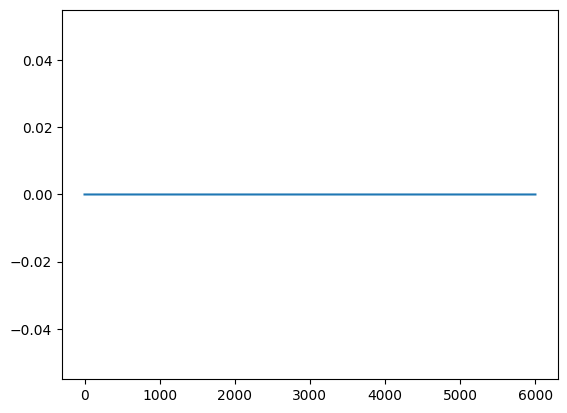

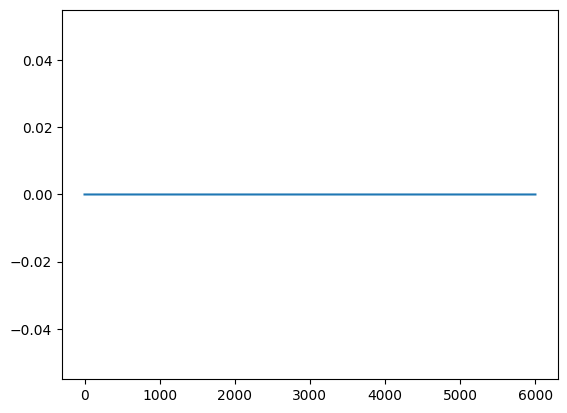

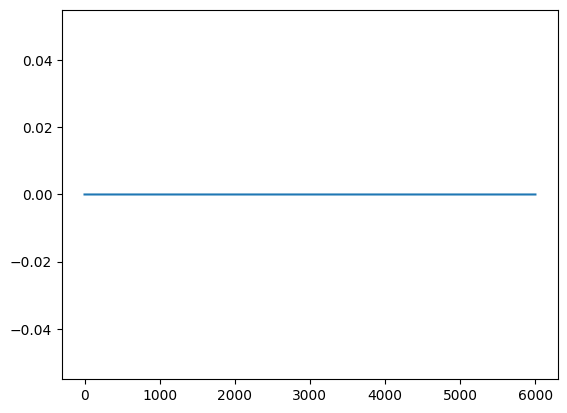

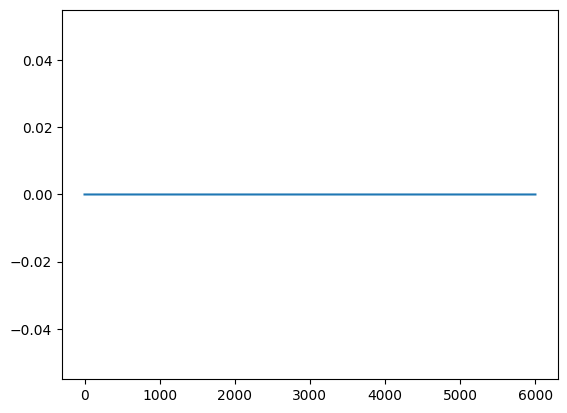

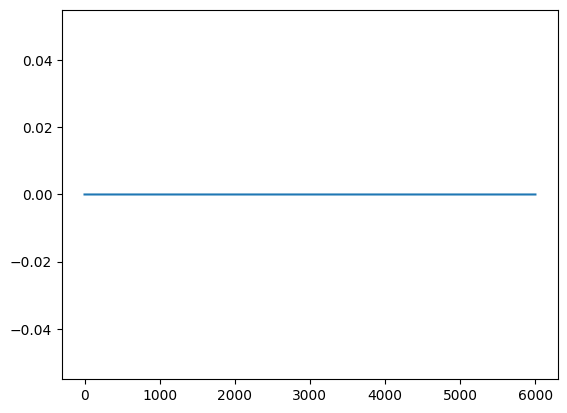

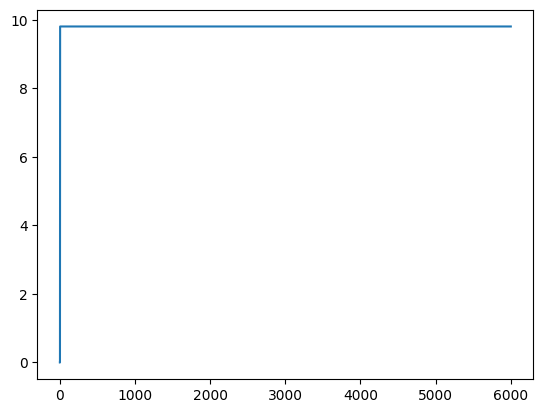

In [4]:
sensed_wrench=controller.sensed_wrench

for i in range(6):
    plt.figure()
    plt.plot(sensed_wrench[:,i])